In [4]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import markov_clustering as mc
from multiprocessing import Pool
from matplotlib.patches import Circle


In [5]:
def read_lines_to_numpy(file_path, start_line, end_line):
    data = []
    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if i < start_line - 1:
                continue  
            if i >= end_line:
                break  
            data.append([float(x) for x in line.split()])

    return np.array(data)

def markov_clustering(graph):
    matrix = nx.to_scipy_sparse_matrix(graph, weight='weight')

    
    result = mc.run_mcl(matrix)  
    clusters = mc.get_clusters(result)  

    return clusters

def map_clusters_to_bins(clusters):
   
    cluster_bins = {}

    for cluster_id, cluster in enumerate(clusters):
        bins = [] 
        for node in cluster:
            bins.append(node) 
        cluster_bins[cluster_id] = bins 

    return cluster_bins

def create_graph_from_matrix(matrix):
    N = matrix.shape[0]-1  #
    G = nx.Graph() 

    for i in range(N):
        for j in range(N):
            if i > j:
                G.add_node((i, j), value=matrix[i, j])

    for i in range(N):
        for j in range(N):
            if i + 1 < N: 
                weight = (matrix[i, j] + matrix[i + 1, j]) / 2
                G.add_edge((i, j), (i + 1, j), weight=weight)
            if j + 1 < N: 
                weight = (matrix[i, j] + matrix[i, j + 1]) / 2
                G.add_edge((i, j), (i, j + 1), weight=weight)

    return G

def remove_duplicates(rectangles):
    unique_rectangles = []
    for rect in rectangles:
        normalized_rect = sorted(rect[:2]) + sorted(rect[2:])
        if normalized_rect not in unique_rectangles:
            unique_rectangles.append(normalized_rect)
    return unique_rectangles

def is_overlapping(rect1, rect2):
    # rect: [min_x, max_x, min_y, max_y]
    return not (rect1[1] < rect2[0] or rect2[1] < rect1[0] or rect1[3] < rect2[2] or rect2[3] < rect1[2])

def merge_rectangles(rect1, rect2):
    min_x = min(rect1[0], rect2[0])
    max_x = max(rect1[1], rect2[1])
    min_y = min(rect1[2], rect2[2])
    max_y = max(rect1[3], rect2[3])
    return [min_x, max_x, min_y, max_y]

def merge_overlapping_rectangles(rectangles):
    merged = []
    while rectangles:
        rect = rectangles.pop(0)
        index = 0
        while index < len(rectangles):
            if is_overlapping(rect, rectangles[index]):
                rect = merge_rectangles(rect, rectangles.pop(index))
            else:
                index += 1
        merged.append(rect)
    return merged

def count_lines_in_file(filename):
    with open(filename, 'r') as file:
        line_count = sum(1 for line in file)
    return line_count

def process_window(mat_index):
    print(mat_index)
    file_path = '/mnt/disk1/duanran/data/hic_bulk_data/GM12878_10kb_dense/GM128782'
    start_line = (mat_index-1) * window_size
    end_line = mat_index * window_size
    line_length = end_line - start_line
    sub_mat = read_lines_to_numpy(file_path, start_line, end_line)
    sub_mat = sub_mat[:, start_line:end_line]

    # 构建图
    print('build graph')
    G = create_graph_from_matrix(sub_mat)
    print('build ok')
    print('begin cluster')
    clusters = markov_clustering(G)
    print('cluster ok')

    large_clusters = [cluster for cluster in clusters if 8 < len(cluster) < 30]

    all_x = []
    all_y = []
    for cccc in large_clusters:
        bin_list_x = []
        bin_list_y = []
        for value in cccc:
            x = value % line_length
            y = value // line_length
            bin_list_x.append(x)
            bin_list_y.append(y)
        all_x.append(bin_list_x)
        all_y.append(bin_list_y)

    range_list = []
    for index in range(len(all_x)):
        min_x = min(all_x[index])
        max_x = max(all_x[index])
        max_y = max(all_y[index])
        min_y = min(all_y[index])
        ran_l = [min_x, max_x, min_y, max_y]
        range_list.append(ran_l)

    print('begin location')
    binzhi_list = []
    abso_list =[]
    for index in range(len(range_list)):
        min_x, max_x, min_y, max_y = range_list[index]

        center = sub_mat[min_x:max_x, min_y:max_y]
        center_mean = np.mean(center)

        top_left = sub_mat[min_x-3:min_x, min_y-3:min_y]
        top_right = sub_mat[min_x-3:min_x, max_y:max_y+3]
        bottom_left = sub_mat[max_x:max_x+3, min_y-3:min_y]
        bottom_right = sub_mat[max_x:max_x+3, max_y:max_y+3]
        top_mean = np.mean(top_left) if top_left.size > 0 else 0
        right_mean = np.mean(top_right) if top_right.size > 0 else 0
        bottom_mean = np.mean(bottom_left) if bottom_left.size > 0 else 0
        left_mean = np.mean(bottom_right) if bottom_right.size > 0 else 0

        if center_mean > top_mean and center_mean > right_mean and center_mean > bottom_mean and center_mean > left_mean:
            if center_mean < 80:
                if center_mean > 35:
                    binzhi_list.append([min_x, max_x, min_y, max_y])

        new_list = []
        for vvv in binzhi_list:
            new_list.append(vvv)
            new_list.append([vvv[2], vvv[3], vvv[0], vvv[1]])

        unique_list = remove_duplicates(new_list)

        merged_list = merge_overlapping_rectangles(unique_list)


        for me_l in merged_list:
            sub_region = sub_mat[me_l[0]:me_l[1], me_l[2]:me_l[3]]
            flat_index = np.argmax(sub_region)
            local_max_idx = np.unravel_index(flat_index, sub_region.shape)
            absolute_x = local_max_idx[0] + me_l[0]
            absolute_y = local_max_idx[1] + me_l[2]
            abso_list.append([absolute_x,absolute_y])

    normalized_list = [tuple(sorted(point)) for point in abso_list]
    unique_points = list(set(normalized_list))
    unique_points = [list(point) for point in unique_points]
    print('loaction ok')

    return mat_index, unique_points

def process_window2(mat_index,chr_num):
    print(mat_index)
    file_path = '/mnt/disk1/duanran/data/hic_bulk_data/GM12878_10kb_dense/GM12878{0}'.format(chr_num)
    start_line = (mat_index-1) * window_size
    end_line = mat_index * window_size
    line_length = end_line - start_line
    sub_mat = read_lines_to_numpy(file_path, start_line, end_line)
    sub_mat = sub_mat[:, start_line:end_line]

    n = sub_mat.shape[0]
    adjusted_mat = np.copy(sub_mat)
    G = create_graph_from_matrix(adjusted_mat)
    clusters = markov_clustering(G)

    large_clusters = [cluster for cluster in clusters if 8 < len(cluster) < 30]

    cluster_bins = map_clusters_to_bins(large_clusters)

    all_x = []
    all_y = []
    for cccc in large_clusters:
        bin_list_x = []
        bin_list_y = []
        for value in cccc:
            x = value % line_length
            y = value // line_length
            bin_list_x.append(x)
            bin_list_y.append(y)
        all_x.append(bin_list_x)
        all_y.append(bin_list_y)

    range_list = []
    for index in range(len(all_x)):
        min_x = min(all_x[index])
        max_x = max(all_x[index])
        max_y = max(all_y[index])
        min_y = min(all_y[index])
        ran_l = [min_x, max_x, min_y, max_y]
        range_list.append(ran_l)

    binzhi_list = []
    for index in range(len(range_list)):
        min_x, max_x, min_y, max_y = range_list[index]

        center = sub_mat[min_x:max_x, min_y:max_y]
        center_mean = np.mean(center)

        top_left = sub_mat[min_x-3:min_x, min_y-3:min_y]
        top_right = sub_mat[min_x-3:min_x, max_y:max_y+3]
        bottom_left = sub_mat[max_x:max_x+3, min_y-3:min_y]
        bottom_right = sub_mat[max_x:max_x+3, max_y:max_y+3]

        top_mean = np.mean(top_left) if top_left.size > 0 else 0
        right_mean = np.mean(top_right) if top_right.size > 0 else 0
        bottom_mean = np.mean(bottom_left) if bottom_left.size > 0 else 0
        left_mean = np.mean(bottom_right) if bottom_right.size > 0 else 0
        if center_mean > top_mean and center_mean > right_mean and center_mean > bottom_mean and center_mean > left_mean:
            if center_mean < 100:
                if center_mean > 30:
                    binzhi_list.append([min_x, max_x, min_y, max_y])

    new_list = []
    for vvv in binzhi_list:
        new_list.append(vvv)
        new_list.append([vvv[2], vvv[3], vvv[0], vvv[1]])

    unique_list = remove_duplicates(new_list)

    merged_list = merge_overlapping_rectangles(unique_list)

    unique_list_new = []
    for vvvv in merged_list:
        if vvvv[0] >= vvvv[2] and vvvv[1] > vvvv[3]:
            unique_list_new.append(vvvv)

    loop_loaction = []
    for me_l in unique_list_new:
        sub_region = sub_mat[me_l[0]:me_l[1], me_l[2]:me_l[3]]
        flat_index = np.argmax(sub_region)
        local_max_idx = np.unravel_index(flat_index, sub_region.shape)
        absolute_x = local_max_idx[0] + me_l[0]
        absolute_y = local_max_idx[1] + me_l[2]
        loop_loaction.append([absolute_x,absolute_y])


    return mat_index,loop_loaction

def create_graph_from_upper_triangle(matrix):
    N = matrix.shape[0]-1
    G = nx.Graph() 

    for i in range(N):
        for j in range(i + 1, N):  
            G.add_node((i, j), value=matrix[i, j])

    for i in range(N):
        for j in range(i + 1, N): 
            if i + 1 < j:  
                weight = (matrix[i, j] + matrix[i + 1, j]) / 2
                G.add_edge((i, j), (i + 1, j), weight=weight)
            if j + 1 < N:  
                weight = (matrix[i, j] + matrix[i, j + 1]) / 2
                G.add_edge((i, j), (i, j + 1), weight=weight)
    return G

def process_window3(mat_index, chr_num):
    file_path = '/mnt/disk1/duanran/data/hic_bulk_data/GM12878_10kb_dense/GM12878{0}'.format(chr_num)
    start_line = (mat_index - 1) * window_size
    end_line = mat_index * window_size
    line_length = end_line - start_line
    sub_mat = read_lines_to_numpy(file_path, start_line, end_line)

    sub_mat = np.triu(sub_mat[:, start_line:end_line])

    G = create_graph_from_upper_triangle(sub_mat)
    nodes_list = list(G.nodes)
    clusters = markov_clustering(G)

    large_clusters = [cluster for cluster in clusters if 8 < len(cluster) < 30]

    all_x = []
    all_y = []
    for cccc in large_clusters:
        bin_list_x = []
        bin_list_y = []
        for value in cccc:
            x,y = nodes_list[value]
            bin_list_x.append(x)
            bin_list_y.append(y)
        all_x.append(bin_list_x)
        all_y.append(bin_list_y)

    range_list = []
    for index in range(len(all_x)):
        min_x = min(all_x[index])
        max_x = max(all_x[index])
        max_y = max(all_y[index])
        min_y = min(all_y[index])
        ran_l = [min_x, max_x, min_y, max_y]
        range_list.append(ran_l)

    binzhi_list = []
    for index in range(len(range_list)):
        min_x, max_x, min_y, max_y = range_list[index]

        center = sub_mat[min_x:max_x, min_y:max_y]
        center_mean = np.mean(center)

        top_left = sub_mat[max(0, min_x-3):min_x, max(0, min_y-3):min_y]
        top_right = sub_mat[max(0, min_x-3):min_x, max_y:max_y+3]
        bottom_left = sub_mat[max_x:max_x+3, max(0, min_y-3):min_y]
        bottom_right = sub_mat[max_x:max_x+3, max_y:max_y+3]

        top_mean = np.mean(top_left) if top_left.size > 0 else 0
        right_mean = np.mean(top_right) if top_right.size > 0 else 0
        bottom_mean = np.mean(bottom_left) if bottom_left.size > 0 else 0
        left_mean = np.mean(bottom_right) if bottom_right.size > 0 else 0

        if center_mean > top_mean and center_mean > right_mean and center_mean > bottom_mean and center_mean > left_mean:
            if center_mean < 100:
                if center_mean > 30:
                    binzhi_list.append([min_x, max_x, min_y, max_y])


    merged_list = merge_overlapping_rectangles(binzhi_list)

    loop_loaction = []
    for me_l in merged_list:
        sub_region = sub_mat[me_l[0]:me_l[1], me_l[2]:me_l[3]]
        flat_index = np.argmax(sub_region)
        local_max_idx = np.unravel_index(flat_index, sub_region.shape)
        absolute_x = local_max_idx[0] + me_l[0]
        absolute_y = local_max_idx[1] + me_l[2]
        loop_loaction.append([absolute_x, absolute_y])

    return mat_index, loop_loaction

def process_in_parallel(batch_size, cut_num,chr_num):
    result_dict = {}
    args = [(mat_index, chr_num) for mat_index in range(1, cut_num + 1)]
    with Pool(batch_size) as pool:
        results = pool.starmap(process_window3, args)
        for mat_index, merged_list in results:
            result_dict[mat_index] = merged_list
    return result_dict


In [10]:
def time_print():
    timestamp = time.time()

    # 将时间戳转换为可读的格式
    readable_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(timestamp))

    print(readable_time)

time_print()

for chr_num in range(1,2):
    print('chr_num: {0}'.format(chr_num))

    window_size = 100
    filename = '/mnt/disk1/duanran/data/hic_bulk_data/GM12878_10kb_dense/GM12878{0}'.format(chr_num)
    lines = count_lines_in_file(filename)
    cut_num = lines // window_size
    print(cut_num)
    batch_size = 30
    result_dict = process_in_parallel(batch_size, cut_num,chr_num)

    up_loop_list = []
    in_fl = 0
    for key_value in result_dict.keys():
        epoch_loop = result_dict[key_value]
        add_num= (key_value-1) * window_size
        for vv in epoch_loop:
            true_position_loop = np.array(vv)+ add_num
            up_loop_list.append(true_position_loop)

    df = pd.DataFrame(up_loop_list, columns=['x','y'])

    # df.to_csv('/mnt/disk1/duanran/mactop/mactop_chr{0}_loop_fast_1mb.csv'.format(chr_num), index=False)
time_print()

2024-10-18 19:05:11
chr_num: 1
249
2024-10-18 19:05:44


In [8]:
file_path = '/mnt/disk1/duanran/data/hic_bulk_data/GM12878_10kb_dense/GM128781'
start_line = 0
end_line = 10000
line_length = end_line-start_line
sub_mat = read_lines_to_numpy(file_path, start_line, end_line)
sub_mat = sub_mat[:,start_line:end_line]

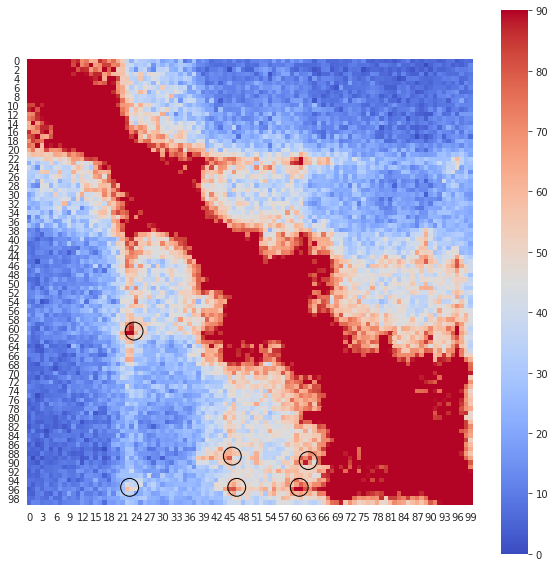

In [40]:
begin = 6700
end = 6800
fig, axes = plt.subplots(figsize=(10, 10))
ax2 = sns.heatmap(sub_mat[begin :end,begin:end], cmap='coolwarm', vmin=0, vmax=90, cbar=True, square=True)
for _, row in df.iterrows():
    # 提取边界值
    lo_x ,lo_y = row['x'],row['y']
    lo_x = lo_x - begin
    lo_y = lo_y - begin
    circle = Circle((lo_x,lo_y), 2, linewidth=1, edgecolor='black', facecolor='none')

    # 在热图上添加矩形
    ax2.add_patch(circle)
# 显示图形
plt.show()